# Business Understanding

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset. Our goals is to (1) answer the business questions proposed and (2) to build a machine learning model to predict flight prices.

## Business questions
- Does price vary with Airlines?
- How is the price affected when tickets are bought in just 1 or 2 days before departure?
- Does ticket price change based on the departure time and arrival time?
- How the price changes with change in Source and Destination?
- How does the ticket price vary between Economy and Business class?

# Data Understanding

## Libraries import and loading the data

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBRegressor

# Pre-prccessing
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# Notebook config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
palette = ["#1F4E79", "#4F81BD", "#A9CCE3", "#D9EAD3", "#BFBFBF", "#595959", "#D0E0EB", "#8FA3BF"]
sns.set_palette(palette)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv("../data/raw/Clean_Dataset.csv")

## Data check-up

In [4]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

The dataset has 300153 rows and 12 columns.


In [5]:
print(f"The dataset has: {len(data.select_dtypes(include = 'object').columns.to_list())} categorical columns.")
print(f"The dataset has: {len(data.select_dtypes(include = 'number').columns.to_list())} numeric columns.")

The dataset has: 8 categorical columns.
The dataset has: 4 numeric columns.


In [6]:
data.nunique().sort_values()

class                    2
stops                    3
airline                  6
source_city              6
departure_time           6
arrival_time             6
destination_city         6
days_left               49
duration               476
flight                1561
price                12157
Unnamed: 0          300153
dtype: int64

We've got to deleted this Unnamed: 0 column (probably the index)

In [7]:
data.isnull().mean()

Unnamed: 0          0.0
airline             0.0
flight              0.0
source_city         0.0
departure_time      0.0
stops               0.0
arrival_time        0.0
destination_city    0.0
class               0.0
duration            0.0
days_left           0.0
price               0.0
dtype: float64

We've got no null data.

In [8]:
data.dtypes

Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [9]:
data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


We don't need further data manipulation besides excluding the columns `Unnamed: 0` and `flight`

In [10]:
df = data.drop(columns = ['Unnamed: 0', 'flight'], axis = 1).copy()
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## EDA

In [11]:
df.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
airline,300153,6,Vistara,127859
source_city,300153,6,Delhi,61343
departure_time,300153,6,Morning,71146
stops,300153,3,one,250863
arrival_time,300153,6,Night,91538
destination_city,300153,6,Mumbai,59097
class,300153,2,Economy,206666


In [12]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.22,7.19,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.00,13.56,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.66,22697.77,1105.00,4783.00,7425.00,42521.00,123071.00


In [13]:
print(f"Target Skewness and Kurtosis")
print("=" * 30)
print(f"Price Skewness: {df['price'].skew():.4f}")
print(f"Price Kurtosis: {df['price'].kurt():.4f}")

Target Skewness and Kurtosis
Price Skewness: 1.0614
Price Kurtosis: -0.3963


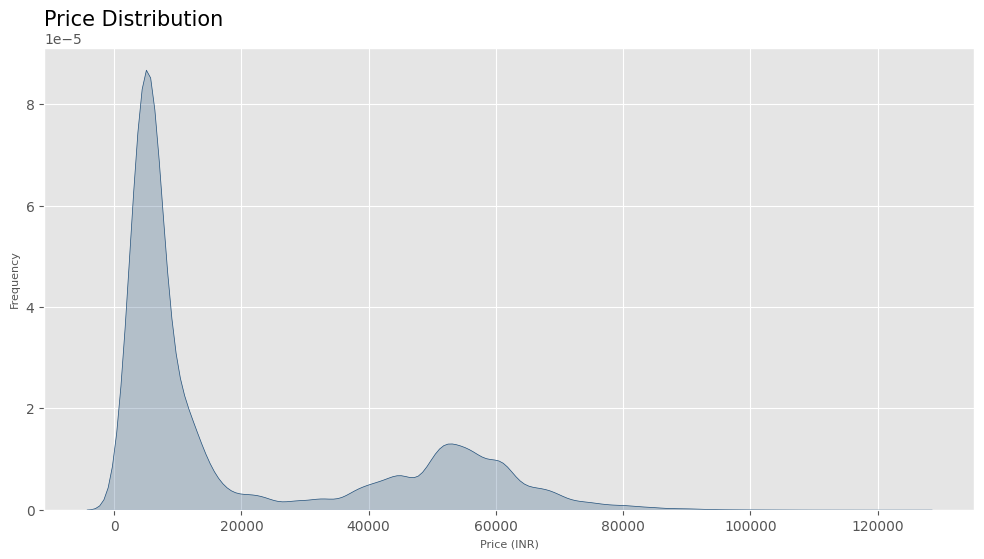

In [14]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(df.price, fill = True)

ax.set_title("Price Distribution", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Price (INR)", fontsize = 8)
ax.set_ylabel("Frequency", fontsize = 8)
plt.show()

Our target is right-skewed, which may be caused by the price difference between the flight classes.

### Does price vary with Airlines?

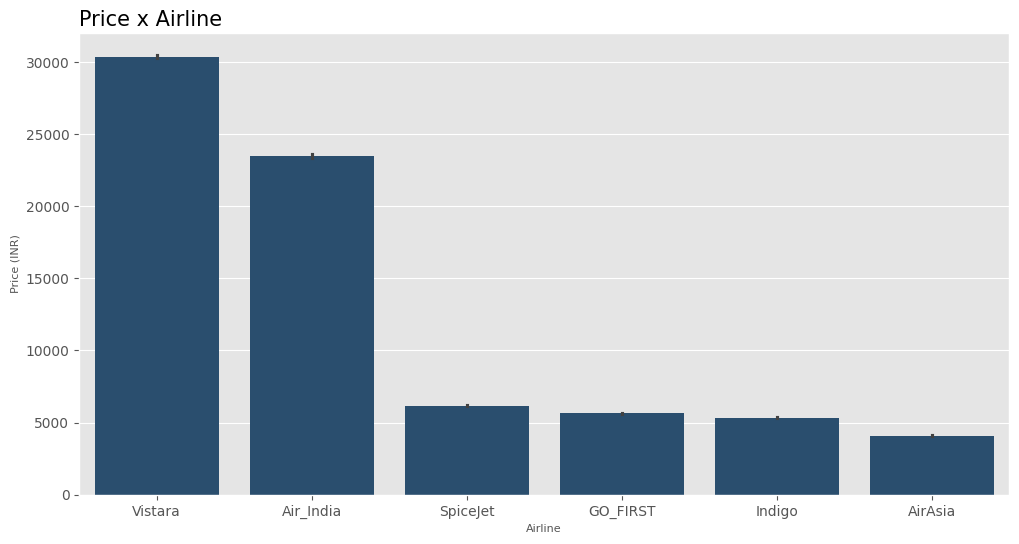

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.airline, y = df.price, color = '#1F4E79', order = df.groupby('airline')['price'].mean().sort_values(ascending=False).index)
ax.set_title("Price x Airline", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Airline", fontsize = 8)
ax.set_ylabel("Price (INR)", fontsize = 8)
plt.show()

### Does price vary with class?

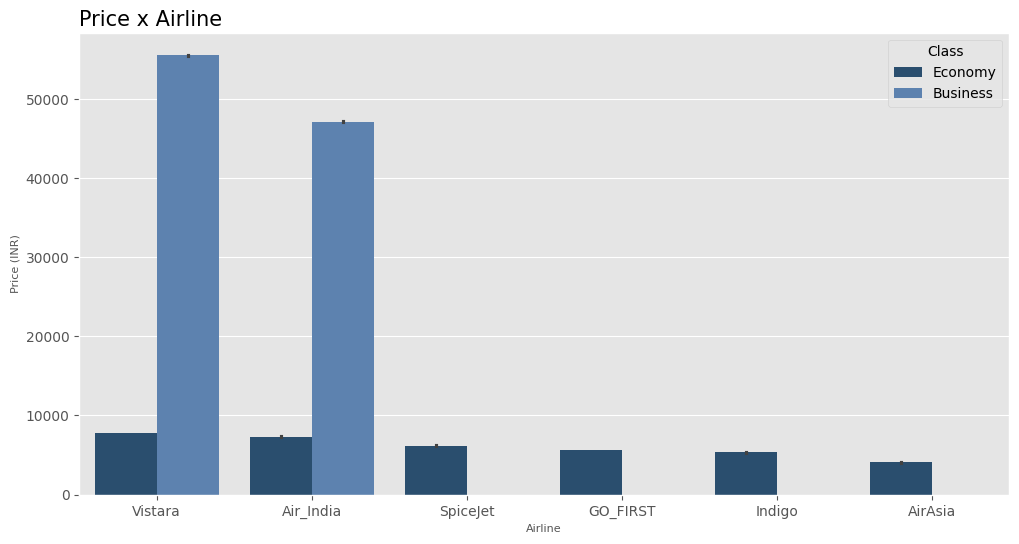

In [16]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.airline, y = df.price, hue = df['class'],order = df.groupby('airline')['price'].mean().sort_values(ascending=False).index)
ax.set_title("Price x Airline", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Airline", fontsize = 8)
ax.set_ylabel("Price (INR)", fontsize = 8)
ax.legend(title = 'Class')
plt.show()

Vistara and Air India have higher prices, but does it remain this way when looking only at economy class flights?

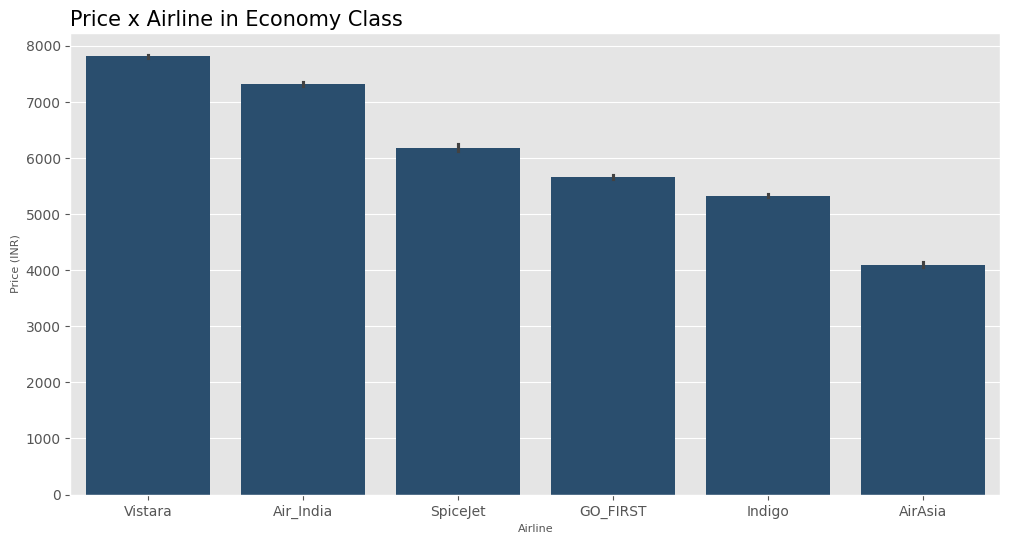

In [17]:
econ = df[df['class'] == 'Economy']

fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = econ.airline, y = econ.price, color = '#1F4E79', order = econ.groupby('airline')['price'].mean().sort_values(ascending=False).index)
ax.set_title("Price x Airline in Economy Class", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Airline", fontsize = 8)
ax.set_ylabel("Price (INR)", fontsize = 8)
plt.show()

Vistara and Air India still have the higher prices.

### How is the price affected when tickets are bought in just 1 or 2 days before departure?

In [18]:
def days(i):
    if i > 2:
        return 'Over 2 days'
    else:
        return 'Under 2 days'

In [19]:
df_days = df.copy()
df_days['days'] = df['days_left'].apply(days)

In [20]:
days = df_days.groupby("days").agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
days

,days,price_mean,price_median
0,Over 2 days,20757.498484,7347.0
1,Under 2 days,27421.169326,16739.0


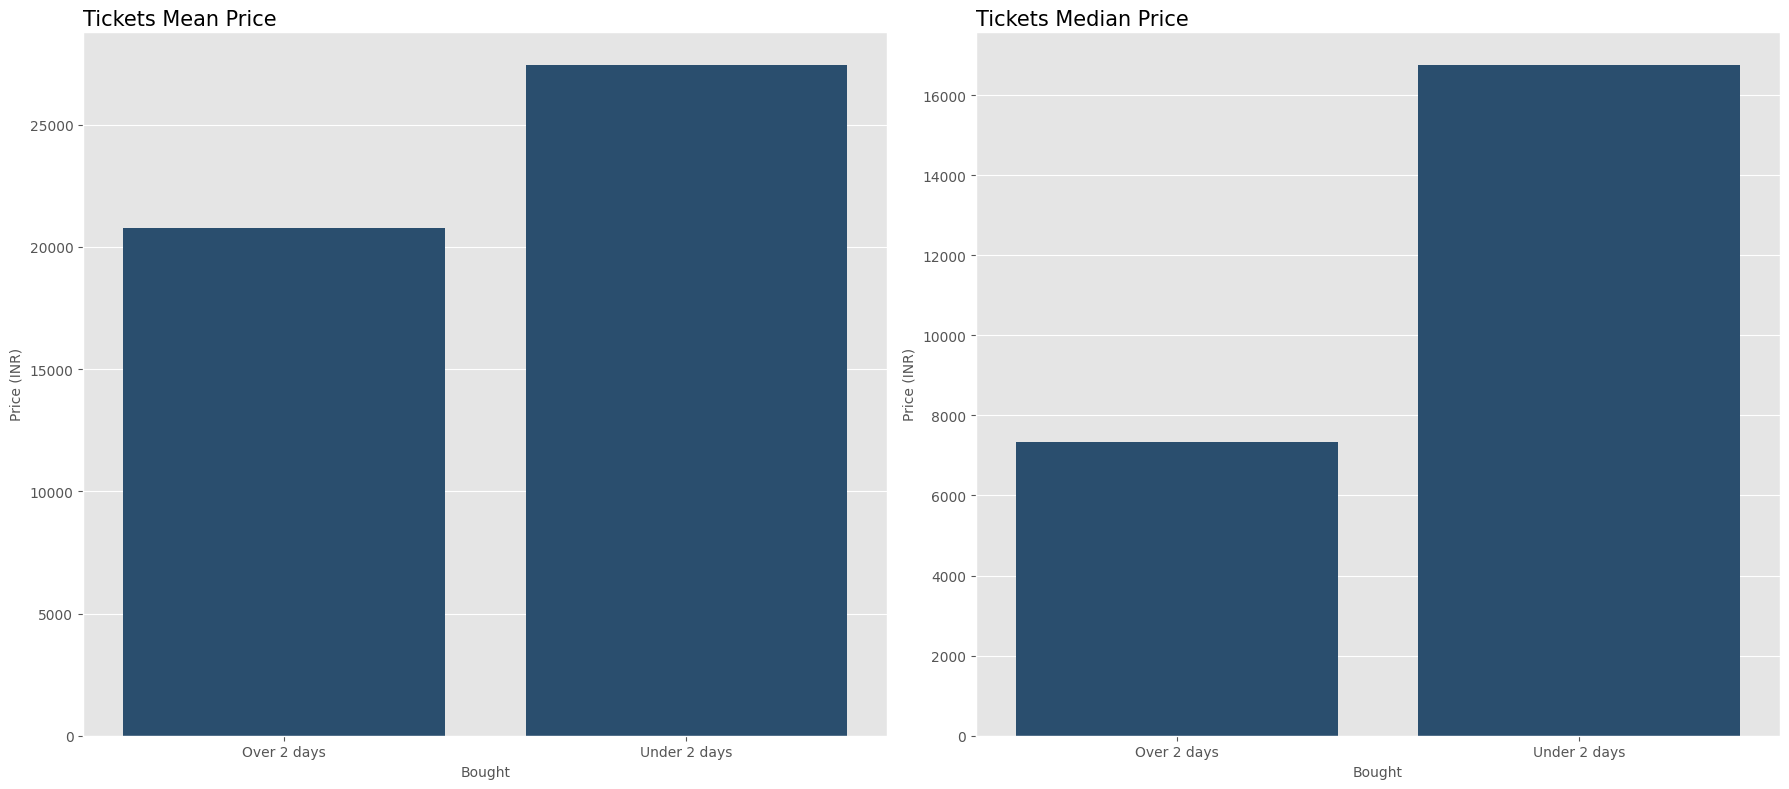

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = days.days, y = days.price_mean)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Bought", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = days.days, y = days.price_median)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Bought", fontsize = 10)
axes[1].set_ylabel("Price (INR)", fontsize = 10)

plt.tight_layout()
plt.show()

The price of airline tickets tends to be higher the closer you are to the flight date.

### Does ticket price change based on the departure time and arrival time?

In [22]:
departure = df.groupby(["departure_time"]).agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
departure

,departure_time,price_mean,price_median
0,Afternoon,18179.203331,6663.0
1,Early_Morning,20370.676718,7212.0
2,Evening,21232.361894,7425.0
3,Late_Night,9295.299387,4499.0
4,Morning,21630.760254,8112.0
5,Night,23062.146808,7813.0


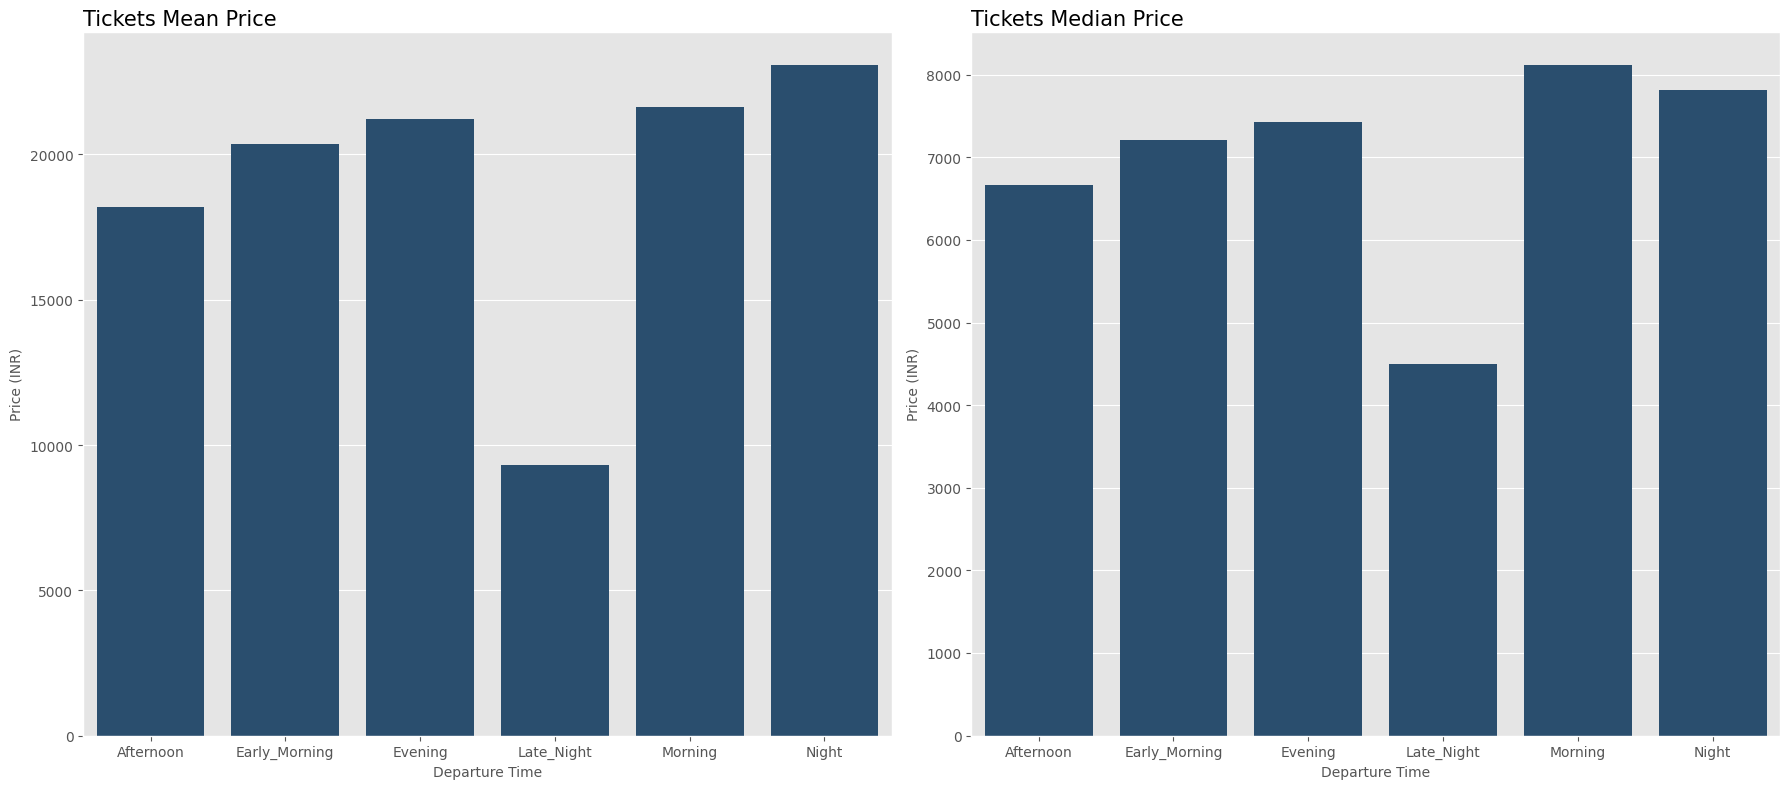

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = departure.departure_time, y = departure.price_mean, color = '#1F4E79', order = departure.departure_time)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Departure Time", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = departure.departure_time, y = departure.price_median, color = '#1F4E79', order = departure.departure_time)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Departure Time", fontsize = 10)
axes[1].set_ylabel("Price (INR)", fontsize = 10)

plt.tight_layout()
plt.show()

Morning and night have the highest prices in departure time.

In [24]:
arrival = df.groupby(["arrival_time"]).agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
arrival

,arrival_time,price_mean,price_median
0,Afternoon,18494.598993,6714.0
1,Early_Morning,14993.139521,5800.0
2,Evening,23044.371615,8854.0
3,Late_Night,11284.906078,4867.0
4,Morning,22231.076098,7687.0
5,Night,21586.758341,7584.0


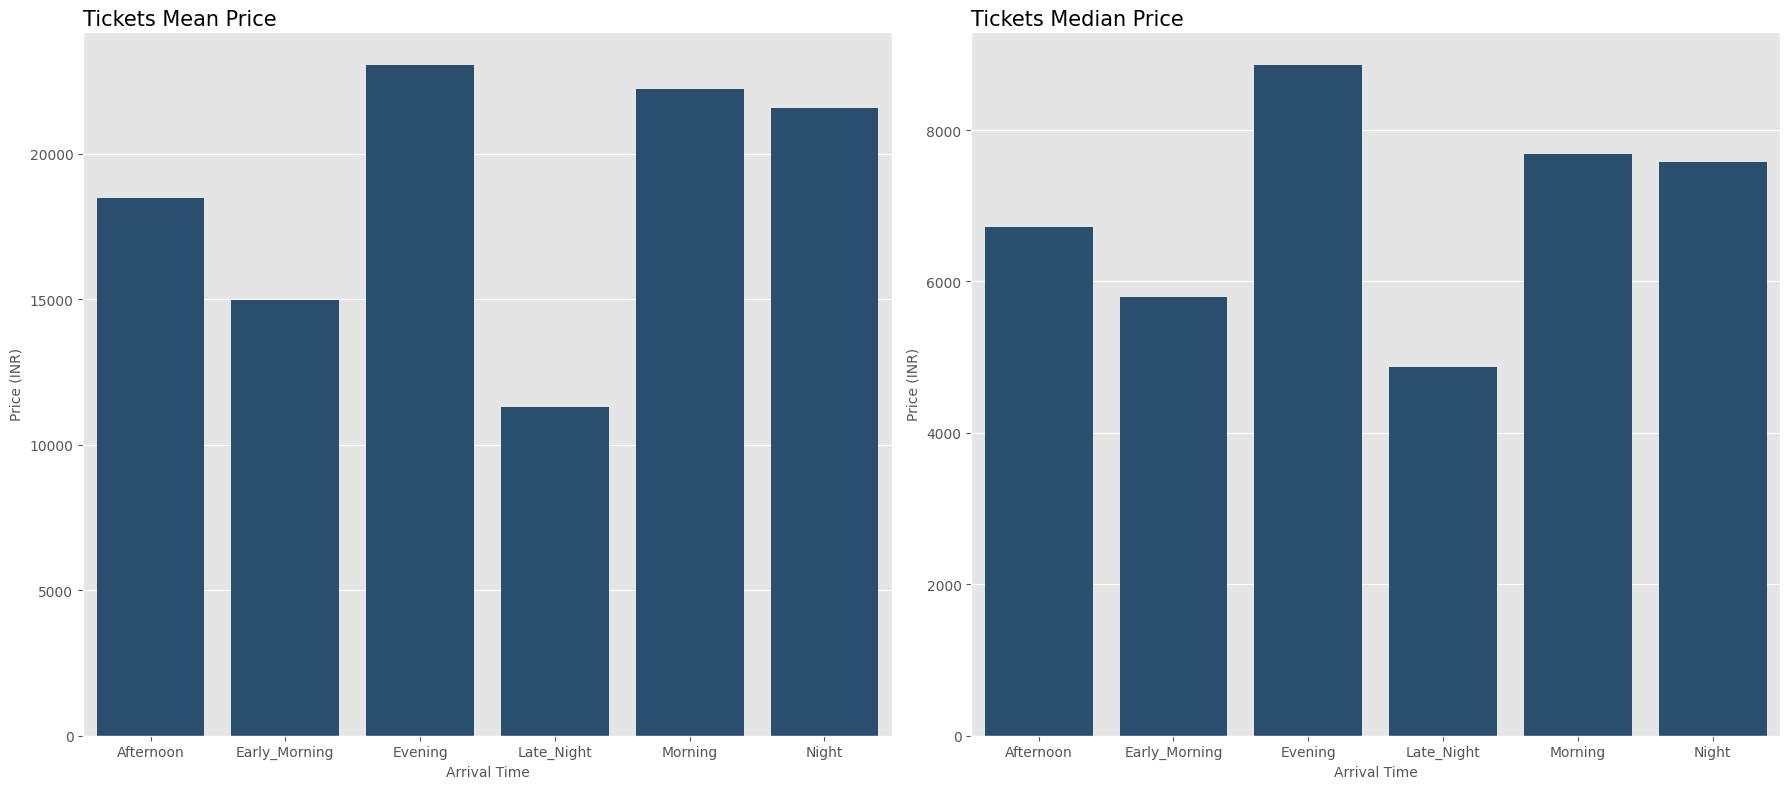

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = arrival.arrival_time, y = arrival.price_mean, color = '#1F4E79', order = arrival.arrival_time)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Arrival Time", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = arrival.arrival_time, y = arrival.price_median, color = '#1F4E79', order = arrival.arrival_time)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Arrival Time", fontsize = 10)
axes[1].set_ylabel("Price (INR)", fontsize = 10)

plt.tight_layout()
plt.show()

Evening and morning have the highest prices in arrival time.

### How the price changes with change in Source and Destination?

In [26]:
source = df.groupby("source_city").agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
source

,source_city,price_mean,price_median
0,Bangalore,21469.460575,7488.0
1,Chennai,21995.339871,7846.0
2,Delhi,18951.326639,6840.0
3,Hyderabad,20155.623879,6855.0
4,Kolkata,21746.235679,7958.0
5,Mumbai,21483.818839,7413.0


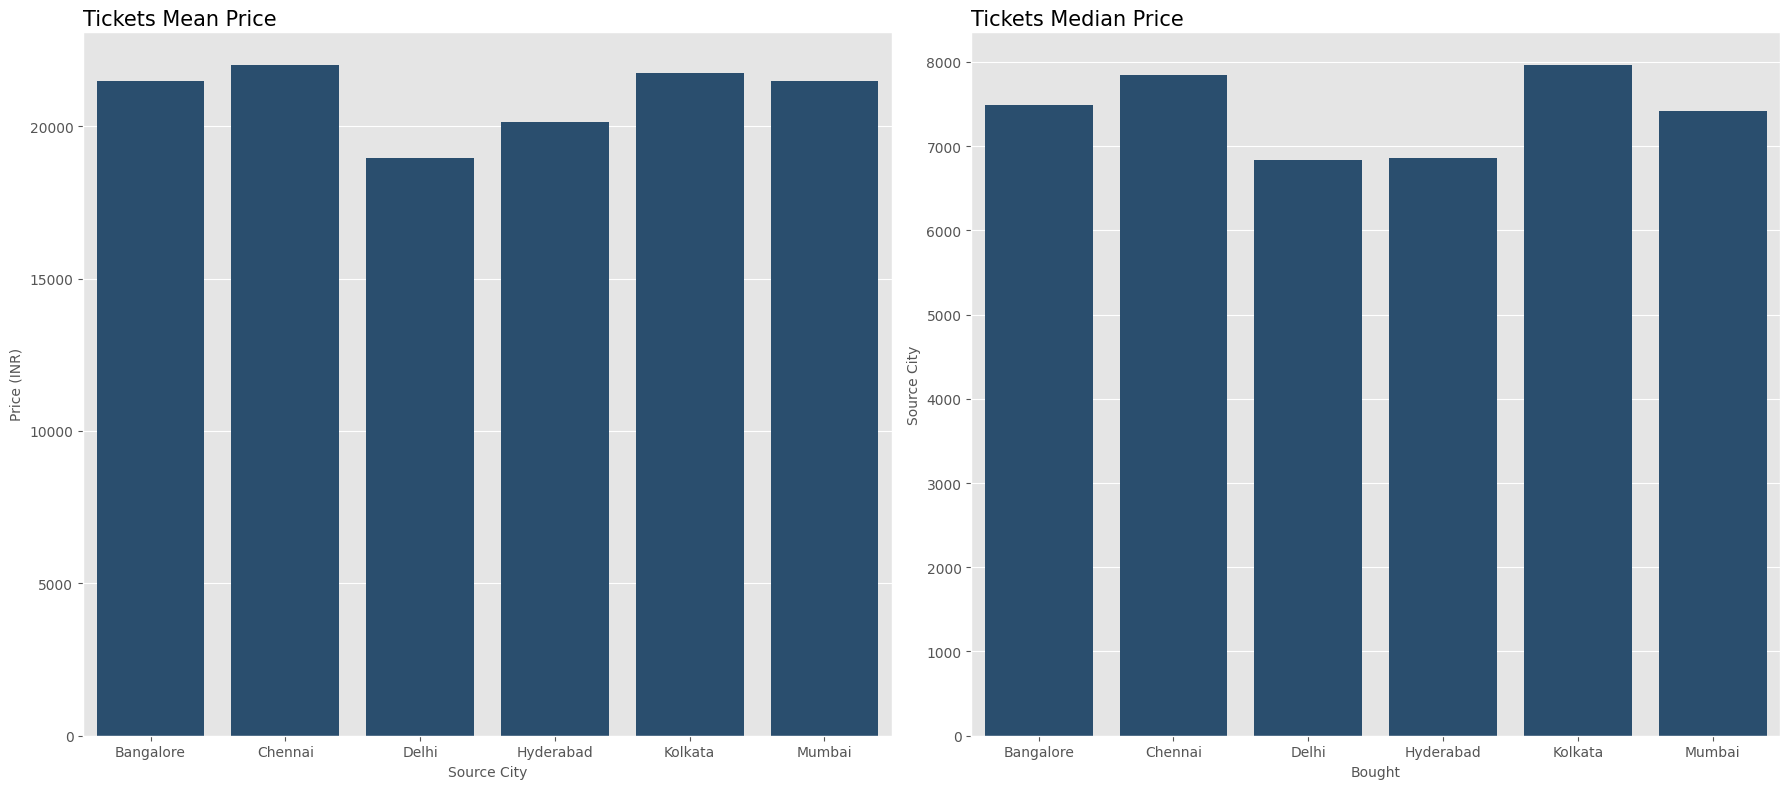

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = source.source_city, y = source.price_mean, color = '#1F4E79', order = source.source_city)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Source City", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = source.source_city, y = source.price_median, color = '#1F4E79', order = source.source_city)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Bought", fontsize = 10)
axes[1].set_ylabel("Source City", fontsize = 10)

plt.tight_layout()
plt.show()

In [28]:
destination = df.groupby("destination_city").agg(price_mean = ('price', 'mean'), price_median = ('price', 'median')).reset_index()
destination

,destination_city,price_mean,price_median
0,Bangalore,21593.955784,7425.0
1,Chennai,21953.323969,7900.0
2,Delhi,18436.767870,6521.0
3,Hyderabad,20427.661284,7548.0
4,Kolkata,21959.557556,7767.0
5,Mumbai,21372.529469,7496.0


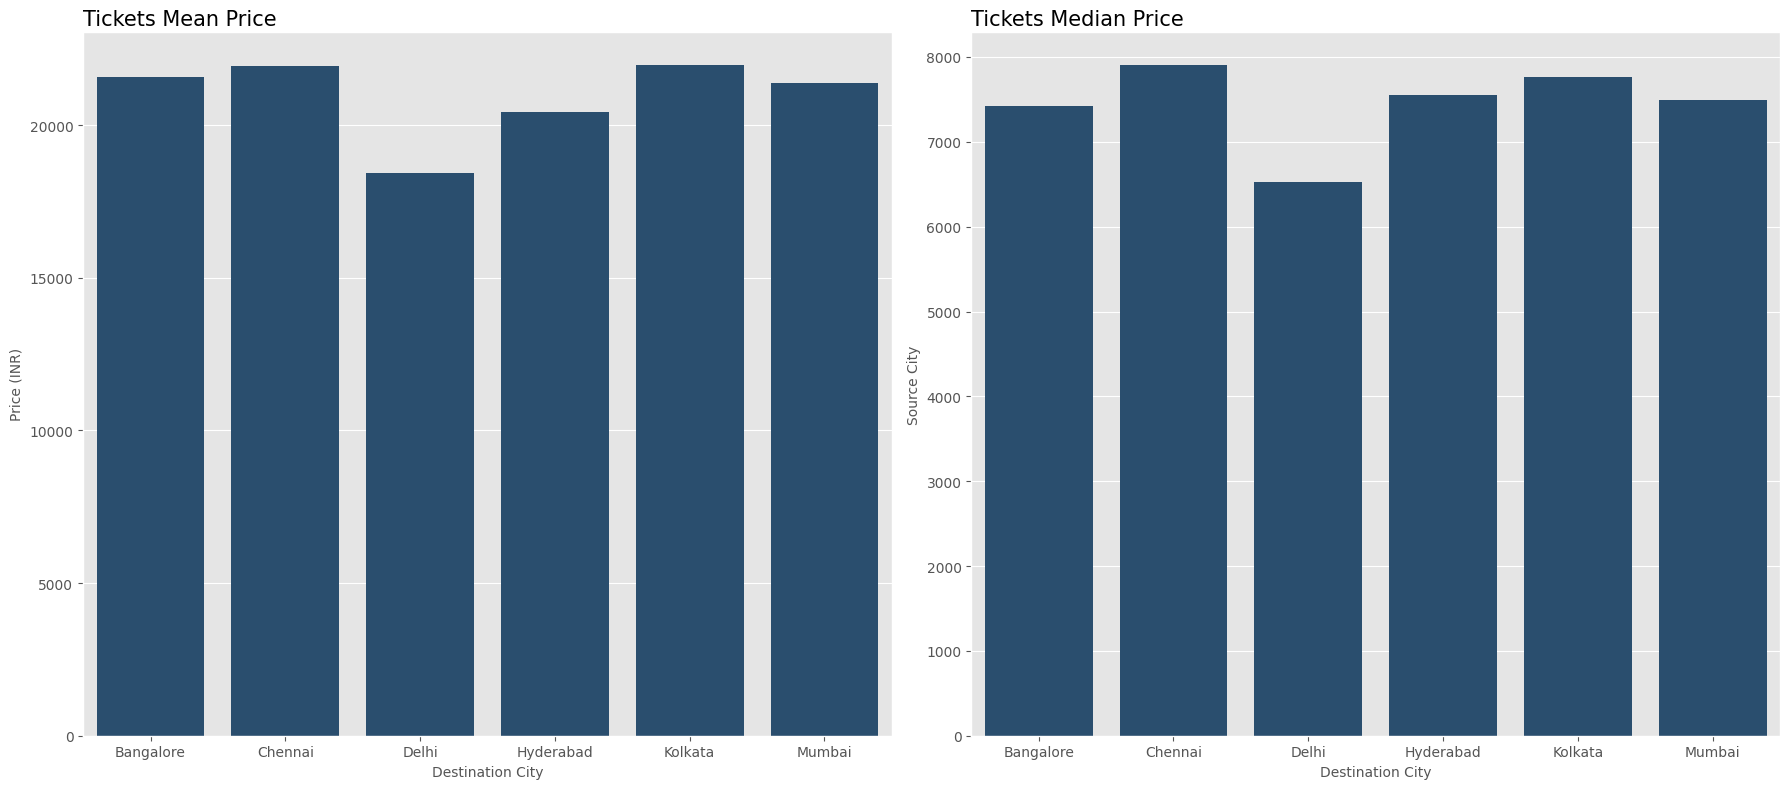

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axes[0], x = destination.destination_city, y = destination.price_mean, color = '#1F4E79', order = destination.destination_city)
axes[0].set_title("Tickets Mean Price", fontsize = 15, pad = 5, loc = 'left')
axes[0].set_xlabel("Destination City", fontsize = 10)
axes[0].set_ylabel("Price (INR)", fontsize = 10)

sns.barplot(ax = axes[1], x = destination.destination_city, y = destination.price_median, color = '#1F4E79', order = destination.destination_city)
axes[1].set_title("Tickets Median Price", fontsize = 15, pad = 5, loc = 'left')
axes[1].set_xlabel("Destination City", fontsize = 10)
axes[1].set_ylabel("Source City", fontsize = 10)

plt.tight_layout()
plt.show()

Kolkata and Chennai have the most expensive tickets.

### Correlation Matrix

In [30]:
dummies = pd.get_dummies(df, prefix = ['airline',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class'], dtype = int)
corr = dummies.corr()

In [31]:
corr.loc['price'].sort_values(ascending = False)

price                           1.000000
class_Business                  0.937860
airline_Vistara                 0.360816
duration                        0.204222
stops_one                       0.199913
airline_Air_India               0.070041
arrival_time_Evening            0.056408
departure_time_Night            0.041768
arrival_time_Morning            0.030379
destination_city_Kolkata        0.020956
arrival_time_Night              0.020344
source_city_Chennai             0.018742
destination_city_Chennai        0.018473
departure_time_Morning          0.018199
source_city_Kolkata             0.016127
destination_city_Bangalore      0.014050
source_city_Mumbai              0.013206
source_city_Bangalore           0.011702
destination_city_Mumbai         0.010533
departure_time_Evening          0.007946
destination_city_Hyderabad     -0.008292
departure_time_Early_Morning   -0.012232
source_city_Hyderabad          -0.012828
departure_time_Late_Night      -0.033768
arrival_time_Aft

The highlights:

- Business class has a quite high correlation with price.
- Vistara has the highest positive correlation with price, which is the highest among the airlines.
- Duration and single stop also have significant correlations.

Why not visualize this?

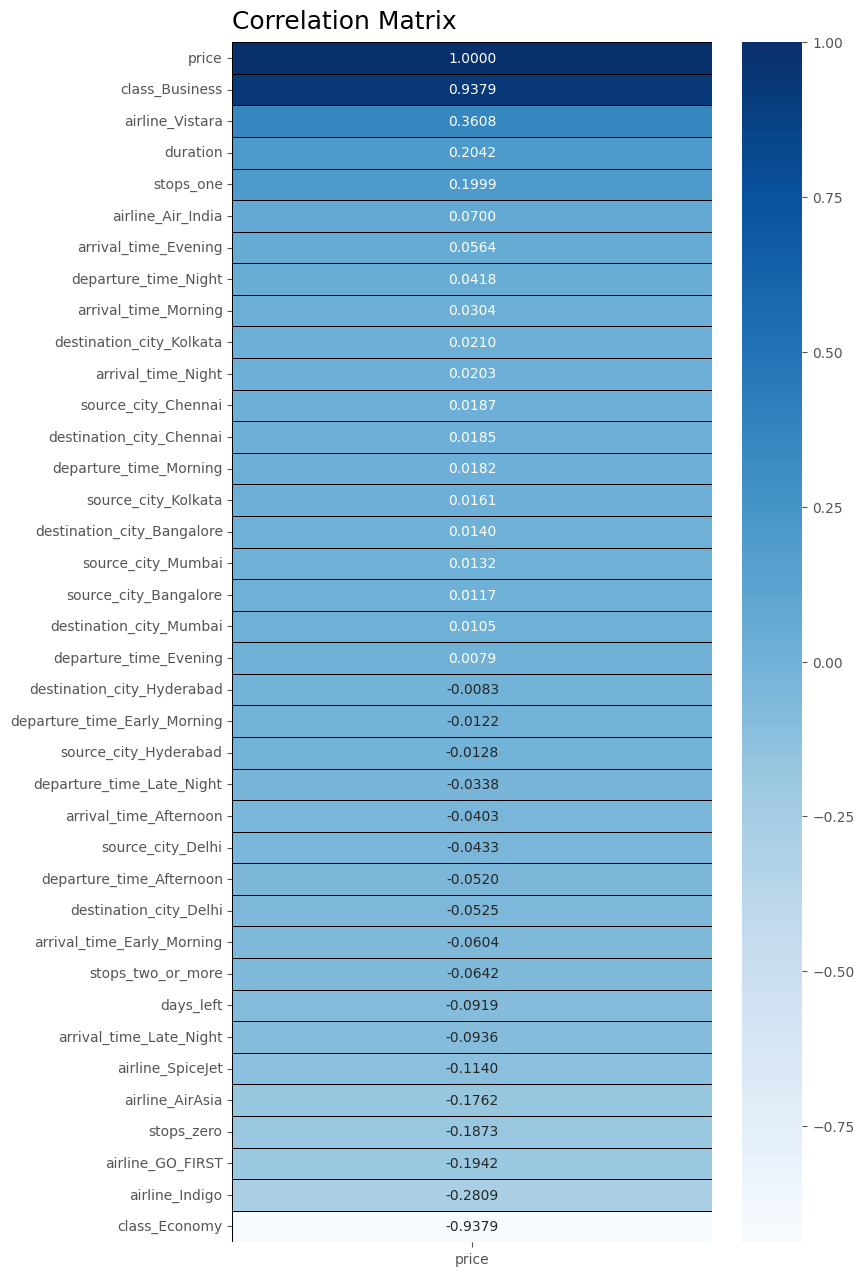

In [32]:
fig = plt.figure(figsize = (6, 12))
ax = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr[['price']].sort_values(by = 'price', ascending = False), annot = True, fmt = '.4f', cmap = 'Blues', linecolor='black', linewidths=0.5)
ax.set_title("Correlation Matrix", fontsize = 18, pad = 10, loc = 'left')
plt.show()

# Data Preparation

In [33]:
features = df.drop(columns = ['price'], axis = 1).columns.to_list()
target = 'price'

X = df[features]
y = df[target]

In [34]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=21)

In [35]:
cat_features = X_train.select_dtypes(exclude = 'number').columns.to_list()
num_features = X_train.select_dtypes(include = 'number').columns.to_list()

In [36]:
cat_transformer = Pipeline([
    ('imput', SimpleImputer(strategy = "most_frequent")),
    ('enconder', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput', SimpleImputer(strategy = 'median')),
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ])

# Modeling

## The base model

In [37]:
model = XGBRegressor(objective='reg:squarederror', random_state = 21)

reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   TargetEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['duration', 'days_le...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=21, ...))])

In [38]:
y_pred = reg.predict(X_val)

In [39]:
print(f"Validation Set")
print("=" * 30)
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_val, y_pred, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred):.4f}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_val, y_pred):.4f}")
print(f"R2 Score: {metrics.r2_score(y_val, y_pred):.4f}")

Validation Set
MSE: 12790568.0237
RMSE: 3576.3904
MAE: 2048.7408
MAPE: 0.1504
R2 Score: 0.9751


These are the base model results let's work it better with hyperparamer optimization.

## Optimized model

In [40]:
def objective(trial):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = trial.suggest_int("n_estimators", 100, 1000),
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        max_depth = trial.suggest_int("max_depth", 1, 10),
        subsample = trial.suggest_float("subsample", 0.05, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0),
        min_child_weight = trial.suggest_int("min_child_weight", 1, 20),
        random_state = 21
    ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-08-25 18:59:56,491] A new study created in memory with name: no-name-77cb1f25-546f-450e-b906-570e0a907ace
[I 2024-08-25 19:00:02,407] Trial 0 finished with value: 8862.57658862416 and parameters: {'n_estimators': 229, 'learning_rate': 0.024492389628324486, 'max_depth': 6, 'subsample': 0.2550588484785341, 'colsample_bytree': 0.23487901404061928, 'min_child_weight': 9}. Best is trial 0 with value: 8862.57658862416.
[I 2024-08-25 19:00:12,848] Trial 1 finished with value: 13377.321509158486 and parameters: {'n_estimators': 833, 'learning_rate': 0.0011862800787346272, 'max_depth': 2, 'subsample': 0.287177984250061, 'colsample_bytree': 0.597102663039611, 'min_child_weight': 19}. Best is trial 0 with value: 8862.57658862416.
[I 2024-08-25 19:00:17,781] Trial 2 finished with value: 10143.12062061122 and parameters: {'n_estimators': 363, 'learning_rate': 0.005012523465267334, 'max_depth': 1, 'subsample': 0.9066574973209431, 'colsample_bytree': 0.5745271035798778, 'min_child_weight': 6}

In [42]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 956, 'learning_rate': 0.08885057738863303, 'max_depth': 10, 'subsample': 0.560743995211729, 'colsample_bytree': 0.9985920323190209, 'min_child_weight': 9}
Best RMSE: 2622.1551841132173


In [43]:
reg_optuna = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**study.best_params, random_state = 21))
])

reg_optuna.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enconder',
                                                                   TargetEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['duration', 'days_le...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.08885057738863303, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=9, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=956, n_jobs=None,
                              num_parallel_tree=None, random_state=21, ...))])

In [44]:
y_pred_optuna = reg_optuna.predict(X_val)

In [45]:
print("Validation Set - Optimized")
print("=" * 30)
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred_optuna):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_val, y_pred_optuna, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred_optuna):.4f}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_val, y_pred_optuna):.4f}")
print(f"R2 Score: {metrics.r2_score(y_val, y_pred_optuna):.4f}")

Validation Set - Optimized
MSE: 6875697.8096
RMSE: 2622.1552
MAE: 1333.2493
MAPE: 0.0971
R2 Score: 0.9866


Our final model got good metrics in the validation set. The Mean Absolute Percentage Error is arround 9% which shows a good performance, time to evaluate using the test set.

# Evaluation

## The metrics

In [46]:
y_pred_test = reg_optuna.predict(X_test)

In [47]:
print("Test Set")
print("=" * 30)
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred_test, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {metrics.r2_score(y_test, y_pred_test):.4f}")

Test Set
MSE: 6855205.6699
RMSE: 2618.2448
MAE: 1328.5562
MAPE: 0.0962
R2 Score: 0.9868


The model showed good metrics, a high R2 score, and good RMSE and MAE.

## Cross-validation

In [48]:
scoring = metrics.make_scorer(metrics.mean_absolute_error)
cv = KFold(n_splits = 5, shuffle=True, random_state=21)

scores = cross_val_score(reg_optuna, X_train, y_train, cv = cv, scoring = scoring)
print(f'Mean MAE: {scores}')
print(f'General Mean MAE: {scores.mean()}')
print(f'MAE Standard Deviation: {scores.std()}')

Mean MAE: [1393.91755665 1378.22671365 1368.95018009 1383.35412869 1363.1419011 ]
General Mean MAE: 1377.5180960373127
MAE Standard Deviation: 10.803590968524654


We can also see that the model demonstrated good generalization, with no signs of overfitting.

## Visualization

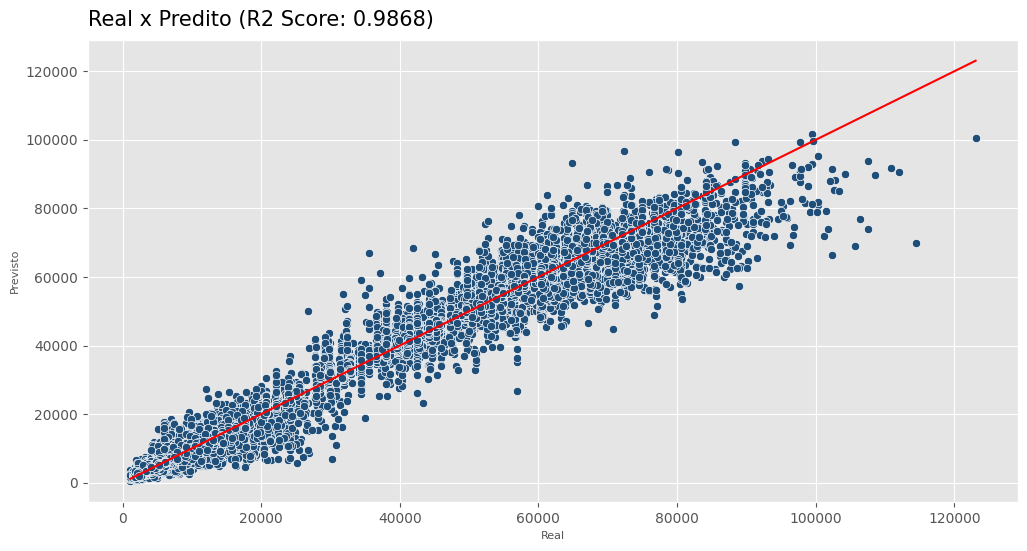

In [49]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
ax.set_title(f"Real x Predito (R2 Score: {metrics.r2_score(y_test, y_pred_test):.4f})", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("Previsto", fontsize = 8)
plt.show()

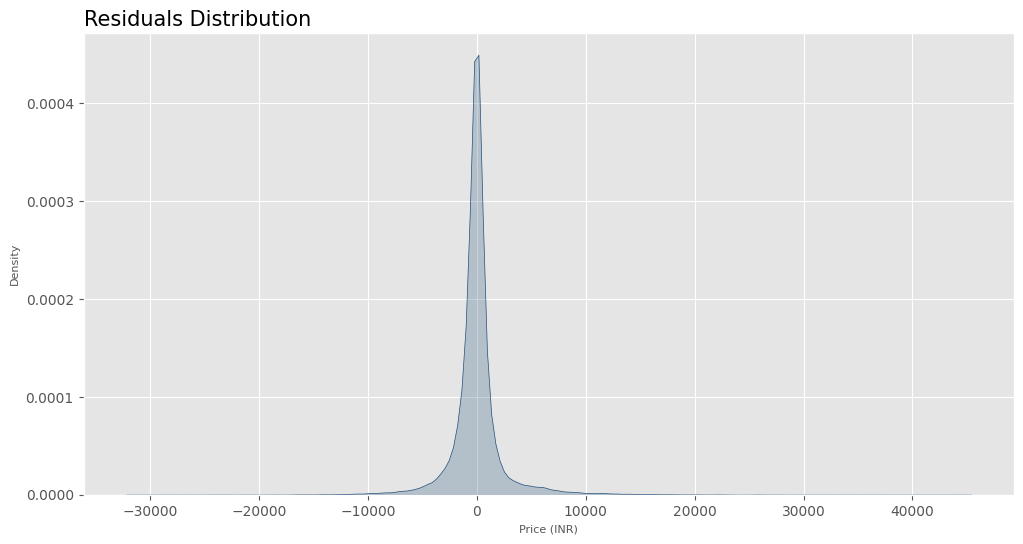

In [50]:
residuals = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(residuals, fill = True)
ax.set_title("Residuals Distribution", fontsize = 15, pad = 5, loc = 'left')
ax.set_xlabel("Price (INR)", fontsize = 8)
ax.set_ylabel("Density", fontsize = 8)
plt.show()


# Conclusions

That's my first time trying to work with the CRISP-DM framework, and it was a good experience throughout this project. Regarding the business questions, we can say that:

- Price varies with class and airline, especially with class. In the case of airlines, there is a significant difference when we consider Vistara and Air India;
- Kolkata and Chennai are the most expensive destinations;
- For arrival time, evening and morning have the highest prices, and for departure, morning and night do;
- Buying tickets in advance is the best way to get good prices.

For the model we got good generalization and results, for more of my work you can find me on:
- [LinkedIn](https://www.linkedin.com/in/andreluizls1/)
- [Github](https://github.com/datalopes1)